In [1]:
using RegERMs # SVM

# Landmarks Path Computation
In this notebook, we train emotion models using the CK+ dataset.
- Read landmarks files and convert it to a normalized space.
- TODO: PCA to avoid unnecessary landmarks
- Based on the normalized landmarks, compute its patch regresssion.
- 

## Function to read and pre-process features from a file
The dataset contains landmarks computed using AAM. These landmarks are stored as a sequence of (x \n y \n) floats dots. Each frame has its own landmark file. To achieve a normalized feature set, it is set the nose as the reference point and the distance between the eyes as the reference size. For each landmark, the final feature is its distance to the reference point divided by the reference size.

In [2]:
using Distances
function readLandmarksFile(filename)
    # println("Getting features from: ", filename)
    
    # Database parser
    dots = map((x)->parse(x), split(readall(filename), ['\n', ' '], limit=0, keep=false));
    getLandmarkPoint(id) = [dots[id*2-1], dots[id*2]];
    
    # Reference Point: nose
    referenceID = 34
    referencePoint = getLandmarkPoint(referenceID)
    
    # Reference Size: distance between eyes
    referenceSize = evaluate(Euclidean(), getLandmarkPoint(40), getLandmarkPoint(43))
    if referenceSize < 1.0 error("Distance between eyes less than one.") end
    
    # Normalized vector
    normalizedVector = []
    for id = 1:round(Int,(length(dots) / 2))
        if id == referenceID; continue end
        append!(normalizedVector, (referencePoint - getLandmarkPoint(id)) / referenceSize)
    end
    
    return normalizedVector
end;

## Function to perform patch regression over the landmarks
Using the above function, all the landmarks from a video sequence are read and normalized. Then, for each landmark trajectory, it is computed its patch regression. The regression uses a third order polinomial function: a + bx + cx^2 + dx^3. The resulting vector contains the parameters [x0,xt,a,b,c,d] for each landmark patch.

In [3]:
# returns patch_xy[file][landmark*2]
function getPatchFeatures(person, shot)
    landmarks4frame = []
    dir = "/home/data/ckplus/Landmarks/$person/$shot"
    for f = readdir("$dir")
        push!(landmarks4frame, readLandmarksFile("$dir/$f"))
    end
    return landmarks4frame
end;

In [4]:
# returns the (x y) patch for a given landmark
function splitXY(patch, landmark)
    x, y = Float64[], Float64[]
    for file = 1:round(Int, length(patch))
        push!(x, patch[file][landmark*2-1])
        push!(y, patch[file][landmark*2])
    end
    return x, y
end;

In [5]:
# return abcd (cubic) params for a given (x, y) patch
using LsqFit
function cubicRegression(x, y)
    model(x, p) = p[1] + p[2] * x + p[3] * x .^ 2 + p[4] * x .^ 3;
    fit = curve_fit(model, x, y, [0.,0.,0.,0.]);
    return fit.param
end;

In [6]:
using Gadfly
function drawCubicCurve(x, y, param, title="no title")
    plot(layer(x=x, y=y, Geom.point, order=1),
         layer((x)->param[1] + param[2] * x + param[3] * x .^ 2 + param[4] * x .^ 3, minimum(x), maximum(x)),
         Guide.title(title))
end;

In [7]:
# performs regression for each landmark on a video clip
# returns [x0, xt, a, b, c, d] * lenght(landmarks), i.e. SVM ready
function landmarksRegressionParams(person, shot, debug=false)
    abcd = []
    patch = getPatchFeatures(person, shot)
    for landmark = 1:floor(Int, length(patch[1]) / 2)
        x, y = splitXY(patch, landmark)
        p = cubicRegression(x, y)
        push!(abcd, minimum(x))
        push!(abcd, maximum(x))
        append!(abcd, p)
        if debug display(drawCubicCurve(x, y, p, "landmark: $landmark")) end
    end
    return abcd
end;

In [8]:
p = landmarksRegressionParams("S100", "001")

0.0004591256569278942 (predicted_residual) >
0.0004589402483798448 (residual) + 5.421010862427522e-20 (eps)


402-element Array{Any,1}:
     1.65455   
     1.71584   
  1286.59      
 -2264.82      
  1329.04      
  -259.824     
     1.62076   
     1.68077   
  -511.435     
   940.845     
  -576.872     
   117.972     
     1.5593    
     ⋮         
    -0.0334427 
     0.00023093
    -0.529941  
    10.7986    
  -148.859     
 -7175.34      
     0.218695  
     0.342725  
   -11.6147    
   123.79      
  -450.833     
   532.077     

In [9]:
using Gadfly
function drawLandmarksCurves(param)
    layers = Array{Gadfly.Layer,1}[]
    for i in 1:floor(Int, length(param) / 6)
        x0, xt, a, b, c, d = param[i*6-5], param[i*6-4], param[i*6-3], param[i*6-2], param[i*6-1], param[i*6]
        push!(layers, layer((x)->a+b*x+c*x.^2+d*x.^3, x0, xt))
    end
    # TODO - a not so hardcoded revision
    plot( layers[1], layers[2], layers[3], layers[4], layers[5], layers[6], layers[7], layers[8], layers[9], layers[10], layers[11], layers[12], layers[13], layers[14], layers[15], layers[16], layers[17], layers[18], layers[19], layers[20], layers[21], layers[22], layers[23], layers[24], layers[25], layers[26], layers[27], layers[28], layers[29], layers[30], layers[31], layers[32], layers[33], layers[34], layers[35], layers[36], layers[37], layers[38], layers[39], layers[40], layers[41], layers[42], layers[43], layers[44], layers[45], layers[46], layers[47], layers[48], layers[49], layers[50], layers[51], layers[52], layers[53], layers[54], layers[55], layers[56], layers[57], layers[58], layers[59], layers[60], layers[61], layers[62], layers[63], layers[64], layers[65], layers[66], layers[67], Guide.title("Facial Landmarks Patchs"))
end;

0.0004588590041056739 (predicted_residual) >
0.0004588578017050192 (residual) + 5.421010862427522e-20 (eps)
0.00045886559132846713 (predicted_residual) >
0.0004588572829820011 (residual) + 5.421010862427522e-20 (eps)


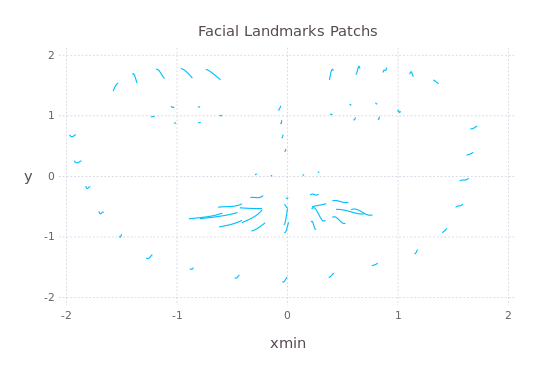

In [10]:
drawLandmarksCurves(p)